In [64]:
# import packages

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import numpy as np
# import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import eli5

import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

In [65]:
# import data

data = pd.read_csv('data/kc_house_data.csv')

In [66]:
# Column Names and descriptions for King County Data Set

# * **id** - unique identified for a house
# * **date** - house was sold
# * **price** -  is prediction target
# * **bedrooms** -  of Bedrooms/House
# * **bathrooms** -  of bathrooms/bedrooms
# * **sqft_living** -  footage of the home
# * **sqft_lot** -  footage of the lot
# * **floors** -  floors (levels) in house
# * **waterfront** - House which has a view to a waterfront
# * **view** - Has been viewed
# * **condition** - How good the condition is ( Overall )
# * **grade** - overall grade given to the housing unit, based on King County grading system
# * **sqft_above** - square footage of house apart from basement
# * **sqft_basement** - square footage of the basement
# * **yr_built** - Built Year
# * **yr_renovated** - Year when house was renovated
# * **zipcode** - zip
# * **lat** - Latitude coordinate
# * **long** - Longitude coordinate
# * **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
# * **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


In [67]:
# stakeholder: real estate agent who wants to sell homes
# Agent needs to explain to sellers what their homes will sell for, how to price them
# price will be target variable

In [68]:
# explore data

data.head()
data.info()
data.describe()

# questions and observations:
# high outliers in price, bedrooms, bathrooms, sqft_living, sqft_lot, & grade
# null values in waterfront, view, yr_renovated
# waterfront has lots of 0s
# turn date (sale date) into a date
# turn sqft_basement into a float (but noticed it has some non-number values, like ?)
# view (number of times house has been viewed), lat, and long are probably not relevant

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,19221.00000,21534.00000,21597.00000,21597.00000,21597.00000,21597.00000,17755.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000
mean,4580474287.77099,540296.57351,3.37320,2.11583,2080.32185,15099.40876,1.49410,0.00760,0.23386,3.40983,7.65792,1788.59684,1970.99968,83.63678,98077.95185,47.56009,-122.21398,1986.62032,12758.28351
std,2876735715.74778,367368.14010,0.92630,0.76898,918.10613,41412.63688,0.53968,0.08682,0.76569,0.65055,1.17320,827.75976,29.37523,399.94641,53.51307,0.13855,0.14072,685.23047,27274.44195
min,1000102.00000,78000.00000,1.00000,0.50000,370.00000,520.00000,1.00000,0.00000,0.00000,1.00000,3.00000,370.00000,1900.00000,0.00000,98001.00000,47.15590,-122.51900,399.00000,651.00000
25%,2123049175.00000,322000.00000,3.00000,1.75000,1430.00000,5040.00000,1.00000,0.00000,0.00000,3.00000,7.00000,1190.00000,1951.00000,0.00000,98033.00000,47.47110,-122.32800,1490.00000,5100.00000
50%,3904930410.00000,450000.00000,3.00000,2.25000,1910.00000,7618.00000,1.50000,0.00000,0.00000,3.00000,7.00000,1560.00000,1975.00000,0.00000,98065.00000,47.57180,-122.23100,1840.00000,7620.00000
75%,7308900490.00000,645000.00000,4.00000,2.50000,2550.00000,10685.00000,2.00000,0.00000,0.00000,4.00000,8.00000,2210.00000,1997.00000,0.00000,98118.00000,47.67800,-122.12500,2360.00000,10083.00000
max,9900000190.00000,7700000.00000,33.00000,8.00000,13540.00000,1651359.00000,3.50000,1.00000,4.00000,5.00000,13.00000,9410.00000,2015.00000,2015.00000,98199.00000,47.77760,-121.31500,6210.00000,871200.00000


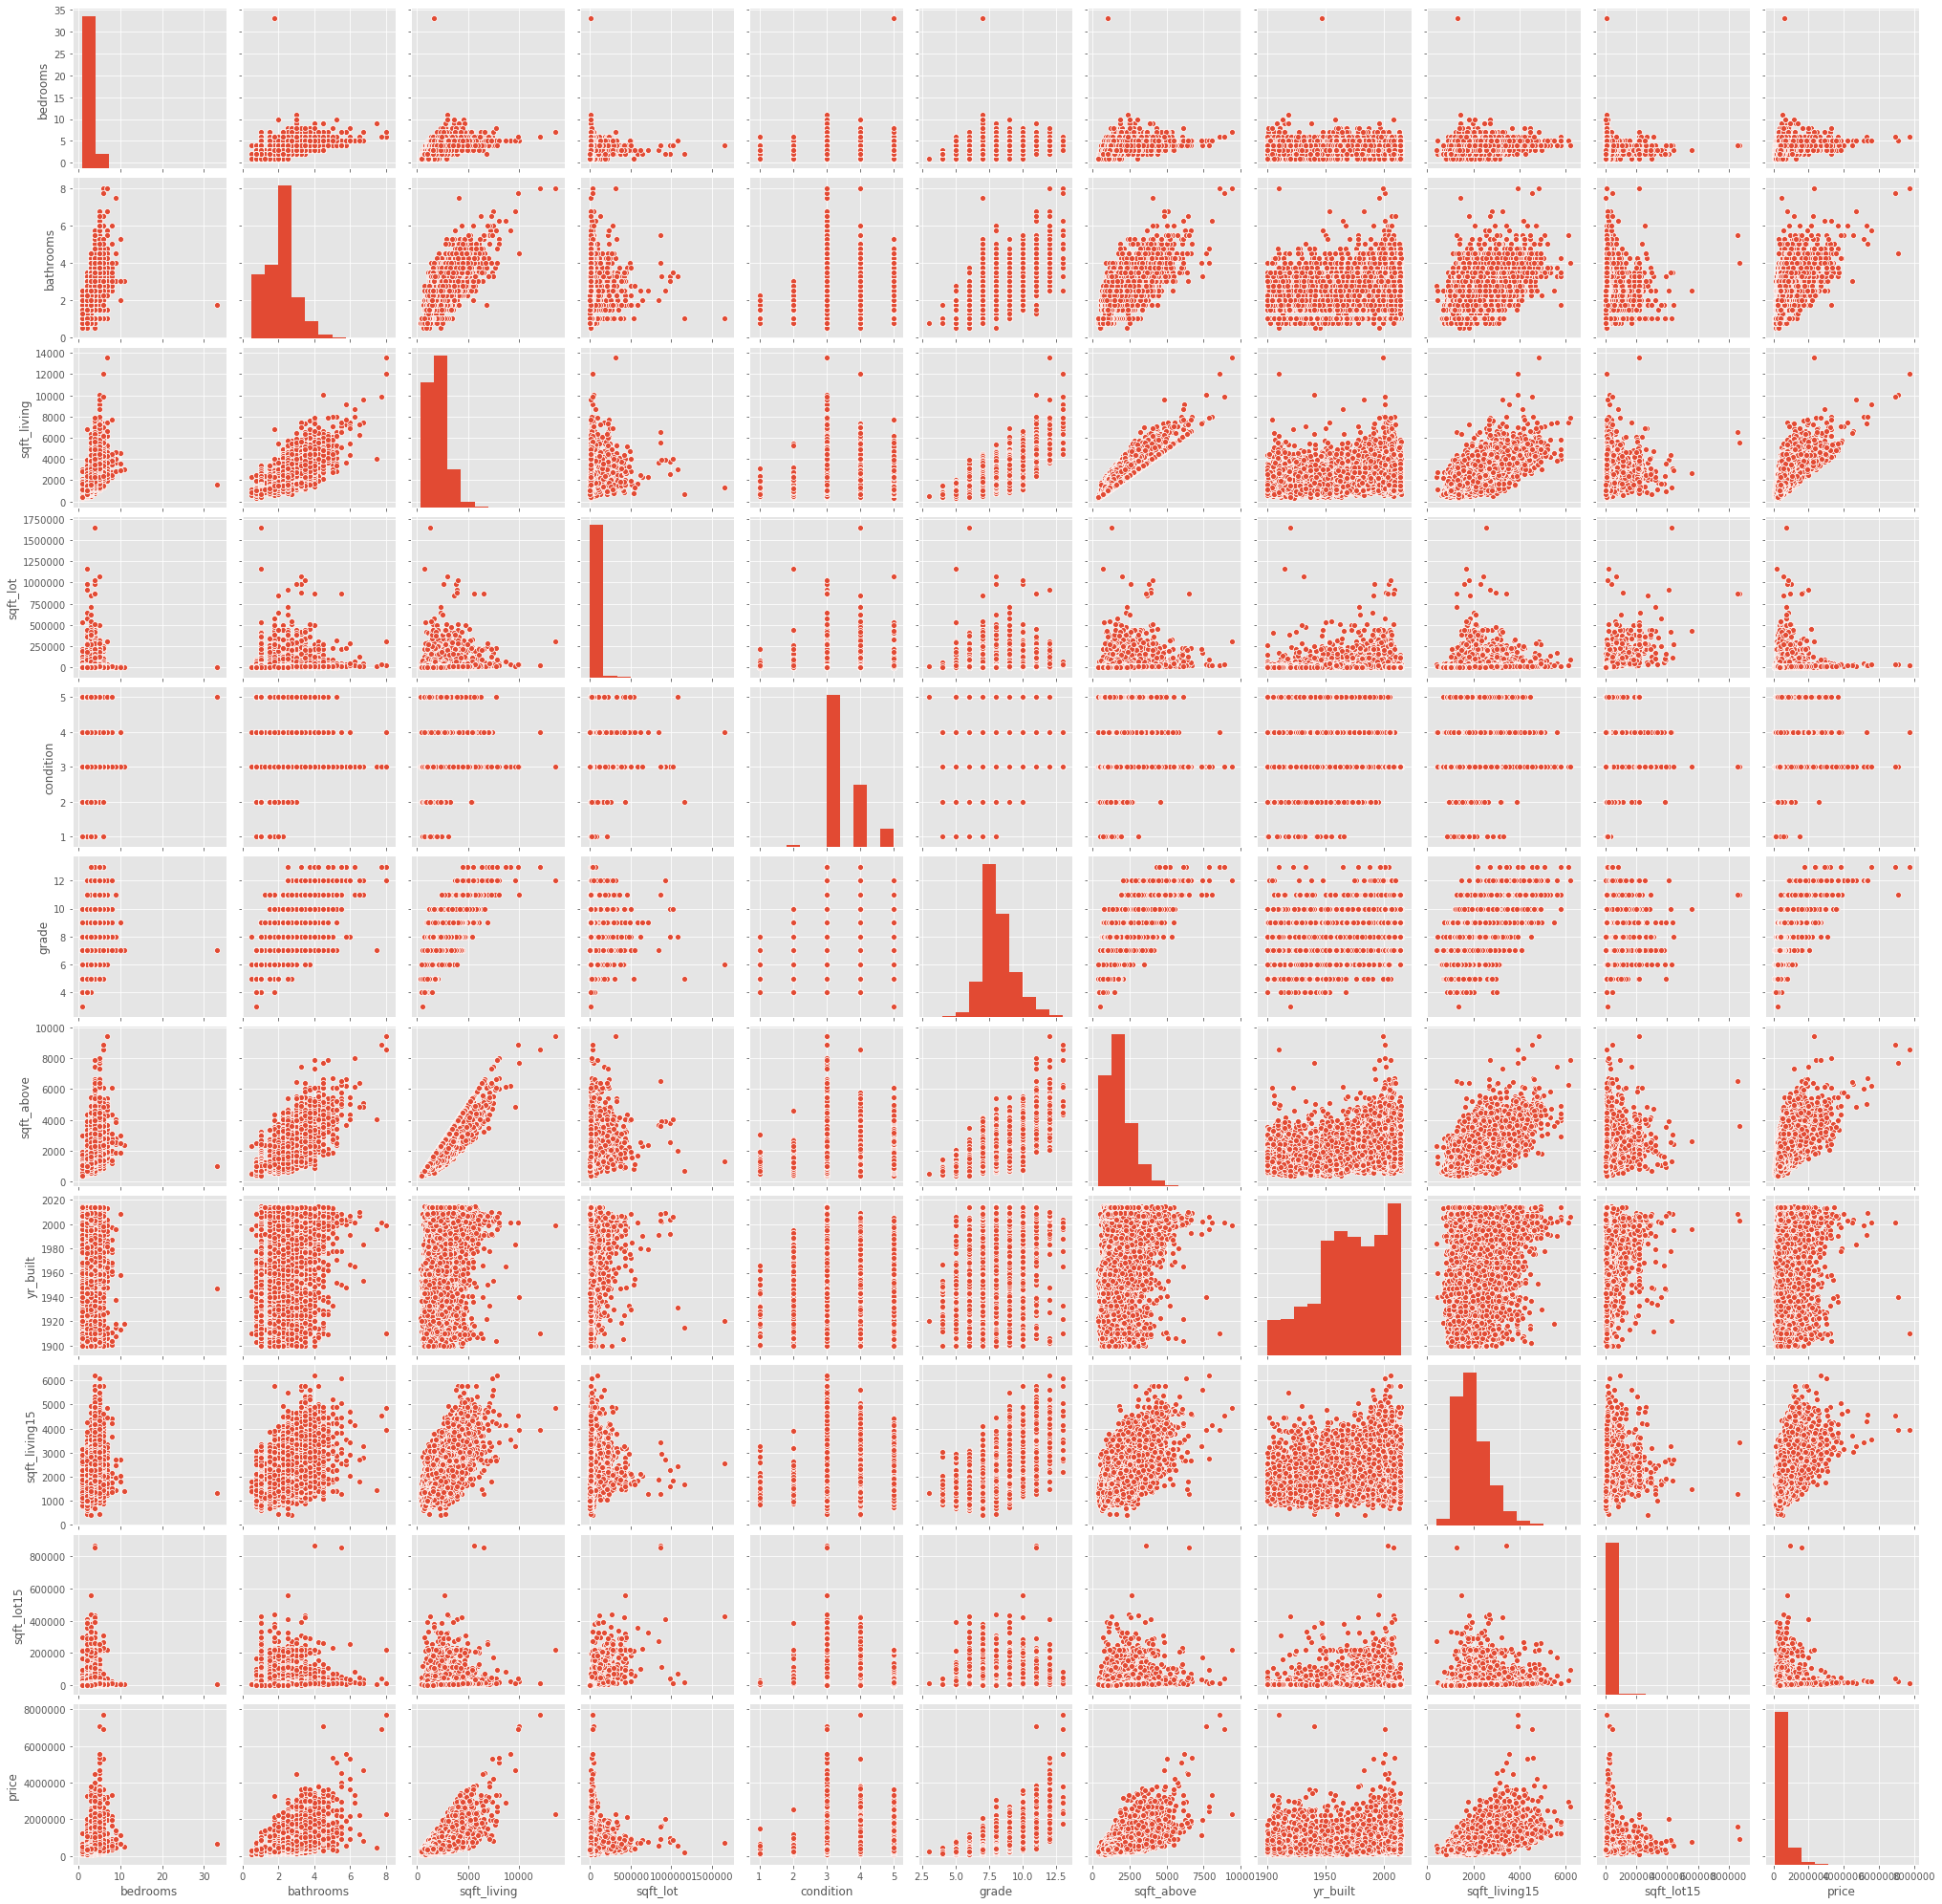

In [69]:
# explore data
# let's try a pairplot to see if anything stands out

cols_of_interest = [ 
                    'bedrooms', 
                    'bathrooms', 
                    'sqft_living',
                    'sqft_lot', 
                    'condition', 
                    'grade', 
                    'sqft_above',
                    'yr_built',  
                    'sqft_living15', 
                    'sqft_lot15',
                    'price']

sns.pairplot(data[cols_of_interest]);

# strongest correlations with price appear to be sqft_living, sqft_above, sqft_living15, grade, bathrooms
# strong correlations between X variables are among these same columns
# all five are correlated with each other
# this multicollinearity could be problematic

# nothing looks normally distributed except maybe grade and bedrooms
# bathrooms, sqft_living, sqft_above, sqft_living15 may be approaching a normal distribution

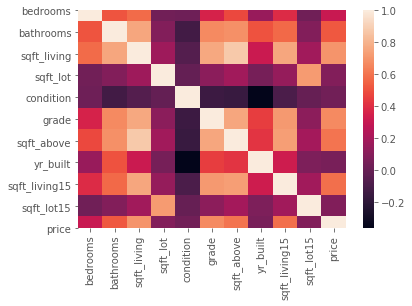

In [70]:
# let's make a heatmap to be sure

sns.heatmap(data[cols_of_interest].corr())

# yes, confirms the observations above

In [71]:
# let's look at the numbers

data[cols_of_interest].corr()

# sqft_living is the best predictor of price so far

,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,price
bedrooms,1.00000,0.51451,0.57821,0.03247,0.02650,0.35656,0.47939,0.15567,0.39341,0.03069,0.30879
bathrooms,0.51451,1.00000,0.75576,0.08837,-0.12648,0.66584,0.68667,0.50717,0.56988,0.08830,0.52591
sqft_living,0.57821,0.75576,1.00000,0.17345,-0.05944,0.76278,0.87645,0.31815,0.75640,0.18434,0.70192
sqft_lot,0.03247,0.08837,0.17345,1.00000,-0.00883,0.11473,0.18414,0.05295,0.14476,0.71820,0.08988
condition,0.02650,-0.12648,-0.05944,-0.00883,1.00000,-0.14690,-0.15890,-0.36159,-0.09307,-0.00313,0.03606
grade,0.35656,0.66584,0.76278,0.11473,-0.14690,1.00000,0.75607,0.44787,0.71387,0.12098,0.66795
sqft_above,0.47939,0.68667,0.87645,0.18414,-0.15890,0.75607,1.00000,0.42404,0.73177,0.19508,0.60537
yr_built,0.15567,0.50717,0.31815,0.05295,-0.36159,0.44787,0.42404,1.00000,0.32638,0.07078,0.05395
sqft_living15,0.39341,0.56988,0.75640,0.14476,-0.09307,0.71387,0.73177,0.32638,1.00000,0.18352,0.58524
sqft_lot15,0.03069,0.08830,0.18434,0.71820,-0.00313,0.12098,0.19508,0.07078,0.18352,1.00000,0.08284


In [72]:
# let's look just at the correlations with price

data[cols_of_interest].corr()['price'].sort_values(ascending=False)

# interesting, sqft_living is further above the rest than I thought

price           1.00000
sqft_living     0.70192
grade           0.66795
sqft_above      0.60537
sqft_living15   0.58524
bathrooms       0.52591
bedrooms        0.30879
sqft_lot        0.08988
sqft_lot15      0.08284
yr_built        0.05395
condition       0.03606
Name: price, dtype: float64

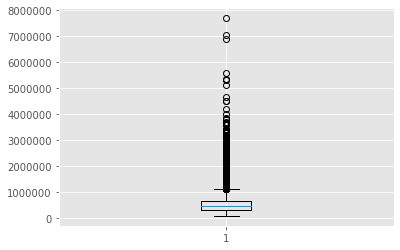

In [73]:
# investigate price outliers

plt.boxplot(data.price); # looks like outliers are probably accurate

In [74]:
# investigate price outliers

data_price_outliers = data.loc[data.price > 1000000].sort_values(by='price', ascending=False)
data_price_outliers.head(500)
data_price_outliers.describe()

# looks like max values for price, bathrooms, sqft_living & grade are accurate
# what about bedrooms (33?) and sqft_lot

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1458.00000,1458.00000,1458.00000,1458.00000,1458.00000,1458.00000,1458.00000,1309.00000,1452.00000,1458.00000,1458.00000,1458.00000,1458.00000,1193.00000,1458.00000,1458.00000,1458.00000,1458.00000,1458.00000
mean,4181277190.71879,1539314.12894,4.07202,3.17284,3803.32236,23357.15501,1.80864,0.07334,1.22383,3.47188,9.76406,3112.65981,1974.71948,241.27410,98069.14403,47.61726,-122.22320,3064.53704,18097.37723
std,2825942293.59474,629062.83540,0.90429,0.86422,1191.60190,57262.99824,0.48633,0.26079,1.52630,0.71042,1.21103,1130.86532,32.54915,651.49001,55.49510,0.06024,0.11421,850.09082,36883.66853
min,31000165.00000,1010000.00000,1.00000,1.00000,1330.00000,609.00000,1.00000,0.00000,0.00000,1.00000,6.00000,1040.00000,1900.00000,0.00000,98004.00000,47.32930,-122.45100,1050.00000,1224.00000
25%,1725059147.50000,1150000.00000,4.00000,2.50000,2982.50000,6918.25000,1.50000,0.00000,0.00000,3.00000,9.00000,2230.00000,1951.25000,0.00000,98027.00000,47.57410,-122.29100,2470.00000,6360.00000
50%,3625650100.00000,1330000.00000,4.00000,3.25000,3660.00000,10916.00000,2.00000,0.00000,0.00000,3.00000,10.00000,2915.00000,1985.00000,0.00000,98053.00000,47.62685,-122.22300,3000.00000,10498.00000
75%,6613001164.50000,1700000.00000,5.00000,3.50000,4370.00000,18797.50000,2.00000,0.00000,3.00000,4.00000,11.00000,3853.75000,2003.00000,0.00000,98112.00000,47.65250,-122.15800,3620.00000,16883.50000
max,9831200520.00000,7700000.00000,10.00000,8.00000,13540.00000,920423.00000,3.50000,1.00000,4.00000,5.00000,13.00000,9410.00000,2015.00000,2015.00000,98199.00000,47.77350,-121.73100,6210.00000,858132.00000


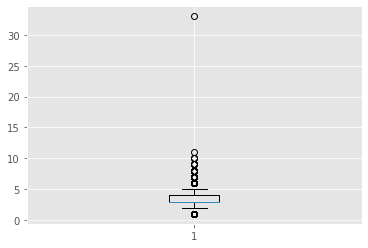

In [75]:
# investigate bedrooms outliers

plt.boxplot(data.bedrooms); # looks like there may be at least 1 inaccurate outlier

In [76]:
# investigate bedrooms outliers

data_br_outliers = data.loc[data.bedrooms > 5].sort_values(by='bedrooms', ascending=False)
data_br_outliers.head(20)

# looks like 33 bedrooms is an outlier due to small sqft_living and number of bathrooms

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,640000.00000,33,1.75000,1620,6000,1.00000,0.00000,0.00000,5,7,1040,580.0,1947,0.00000,98103,47.68780,-122.33100,1330,4700
8748,1773100755,8/21/2014,520000.00000,11,3.00000,3000,4960,2.00000,0.00000,0.00000,3,7,2400,600.0,1918,1999.00000,98106,47.55600,-122.36300,1420,4960
15147,5566100170,10/29/2014,650000.00000,10,2.00000,3610,11914,2.00000,0.00000,0.00000,4,7,3010,600.0,1958,0.00000,98006,47.57050,-122.17500,2040,11914
19239,8812401450,12/29/2014,660000.00000,10,3.00000,2920,3745,2.00000,0.00000,0.00000,4,7,1860,1060.0,1913,0.00000,98105,47.66350,-122.32000,1810,3745
13301,627300145,8/14/2014,1150000.00000,10,5.25000,4590,10920,1.00000,0.00000,2.00000,3,9,2500,2090.0,2008,0.00000,98004,47.58610,-122.11300,2730,10400
16830,8823900290,3/17/2015,1400000.00000,9,4.00000,4620,5508,2.50000,0.00000,0.00000,3,11,3870,750.0,1915,0.00000,98105,47.66840,-122.30900,2710,4320
4092,1997200215,5/7/2014,599999.00000,9,4.50000,3830,6988,2.50000,0.00000,0.00000,3,7,2450,1380.0,1938,0.00000,98103,47.69270,-122.33800,1460,6291
4231,2902200015,1/6/2015,700000.00000,9,3.00000,3680,4400,2.00000,0.00000,0.00000,3,7,2830,850.0,1908,0.00000,98102,47.63740,-122.32400,1960,2450
18428,8823901445,3/13/2015,934000.00000,9,3.00000,2820,4480,2.00000,0.00000,0.00000,3,7,1880,940.0,1918,0.00000,98105,47.66540,-122.30700,2460,4400
6073,9822700190,8/8/2014,1280000.00000,9,4.50000,3650,5000,2.00000,0.00000,0.00000,3,8,2530,1120.0,1915,2010.00000,98105,47.66040,-122.28900,2510,5000


In [77]:
# let's drop the row with 33 bedrooms

data = data.loc[data.bedrooms < 33]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 21 columns):
id               21596 non-null int64
date             21596 non-null object
price            21596 non-null float64
bedrooms         21596 non-null int64
bathrooms        21596 non-null float64
sqft_living      21596 non-null int64
sqft_lot         21596 non-null int64
floors           21596 non-null float64
waterfront       19220 non-null float64
view             21533 non-null float64
condition        21596 non-null int64
grade            21596 non-null int64
sqft_above       21596 non-null int64
sqft_basement    21596 non-null object
yr_built         21596 non-null int64
yr_renovated     17754 non-null float64
zipcode          21596 non-null int64
lat              21596 non-null float64
long             21596 non-null float64
sqft_living15    21596 non-null int64
sqft_lot15       21596 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.6+ MB


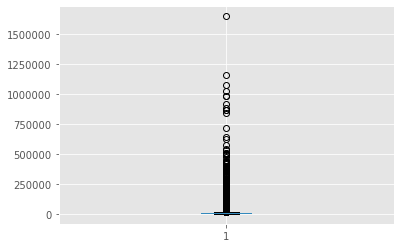

In [78]:
# investigate sqft_lot outliers

plt.boxplot(data.sqft_lot); # hard to say if the max value is inaccurate, let's look at it

In [79]:
# investigate sqft_lot outliers

data_lot_outliers = data.loc[data.sqft_lot > 500000].sort_values(by='sqft_lot', ascending=False)
data_lot_outliers.head(500)
# looks accurate.  checked out the first 3 zip codes and they are rural areas

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1717,1020069017,3/27/2015,700000.00000,4,1.00000,1300,1651359,1.00000,0.00000,3.00000,4,6,1300,0.0,1920,0.00000,98022,47.23130,-122.02300,2560,425581
17305,3326079016,5/4/2015,190000.00000,2,1.00000,710,1164794,1.00000,0.00000,0.00000,2,5,710,0.0,1915,0.00000,98014,47.68880,-121.90900,1680,16730
7640,2623069031,5/21/2014,542500.00000,5,3.25000,3010,1074218,1.50000,nan,0.00000,5,8,2010,1000.0,1931,0.00000,98027,47.45640,-122.00400,2450,68825
7762,2323089009,1/19/2015,855000.00000,4,3.50000,4030,1024068,2.00000,0.00000,0.00000,3,10,4030,0.0,2006,0.00000,98045,47.46190,-121.74400,1830,11700
3945,722069232,9/5/2014,998000.00000,4,3.25000,3770,982998,2.00000,0.00000,0.00000,3,10,3770,0.0,1992,0.00000,98058,47.41400,-122.08700,2290,37141
4437,3626079040,7/30/2014,790000.00000,2,3.00000,2560,982278,1.00000,0.00000,0.00000,3,8,2560,0.0,2004,0.00000,98014,47.69550,-121.86100,1620,40946
6685,2624089007,3/20/2015,2000000.00000,2,2.50000,3900,920423,2.00000,0.00000,0.00000,3,12,3900,0.0,2009,0.00000,98065,47.53710,-121.75600,2720,411962
7070,2724079090,1/5/2015,1650000.00000,4,3.25000,3920,881654,3.00000,nan,3.00000,3,11,3920,?,2002,nan,98024,47.53850,-121.89600,2970,112384
9705,225079036,1/7/2015,937500.00000,4,4.00000,5545,871200,2.00000,0.00000,0.00000,3,11,3605,1940.0,2003,0.00000,98014,47.67600,-121.88200,3420,871200
20436,1125079111,4/15/2015,1600000.00000,4,5.50000,6530,871200,2.00000,0.00000,2.00000,3,11,6530,0.0,2008,0.00000,98014,47.66400,-121.87800,1280,858132


In [80]:
# investigate null values in waterfront

data.waterfront.value_counts() # binary - 1 or 0
data.waterfront.isna().sum() #2376 null values out of 21596
data.waterfront.value_counts() 

# I'm reluctant to drop the rows, which are > 10% of the data
# Only 146 homes are marked as waterfront -- less than 1% of data
# So I'll drop this feature from the analysis

0.00000    19074
1.00000      146
Name: waterfront, dtype: int64

In [81]:
# deal with null values in yr_renovated

data['yr_renovated'].value_counts().head(50)
# 17010 values are 0
# nulls = data['yr_renovated'].isna().sum() #3842 values are null
# many of the values with years are old, e.g. 1930's-1990's

0.00000       17010
2014.00000       73
2003.00000       31
2013.00000       31
2007.00000       30
2000.00000       29
2005.00000       29
1990.00000       22
2004.00000       22
2009.00000       21
1989.00000       20
2006.00000       20
2002.00000       17
1991.00000       16
1998.00000       16
1984.00000       16
1999.00000       15
2008.00000       15
2010.00000       15
2001.00000       15
1983.00000       15
2015.00000       14
1985.00000       14
1986.00000       14
1987.00000       14
1994.00000       14
1992.00000       13
1993.00000       12
1997.00000       12
1995.00000       12
1996.00000       11
1988.00000       11
1970.00000        9
2011.00000        9
1980.00000        8
1982.00000        8
2012.00000        8
1979.00000        7
1977.00000        7
1968.00000        7
1975.00000        5
1964.00000        5
1969.00000        4
1963.00000        4
1973.00000        4
1981.00000        4
1965.00000        4
1978.00000        3
1960.00000        3
1958.00000        3


In [82]:
# create a new column showing homes renovated or not

data['renovated'] = np.where(data['yr_renovated'] > 0, 1, 0)
data['renovated'].value_counts() # only 744 homes show a year renovated

0    20852
1      744
Name: renovated, dtype: int64

In [83]:
# deal with non-number values in sqft_basement
data['sqft_basement'].value_counts() # continuous variable, but has 454 '?' values
# also 12826 0 values.  Do these homes truly not have basements?

# per cent of data that is missing:
missing_sqft_basement = round((len(data.loc[data['sqft_basement'] == '?'])/len(data))*100, 2)
print(missing_sqft_basement, "% of basement data is missing")

# per cent of data that is zero:
missing_sqft_basement = round((len(data.loc[data['sqft_basement'] == '0.0'])/len(data))*100, 2)
print(missing_sqft_basement, "% of basement data is zero")

2.1 % of basement data is missing
59.39 % of basement data is zero


In [84]:
# for now, let's fill missing values with zero, since that's the median
# probably this data will not be a predictor, but let's check

#replace all '?' values with '0'
data.loc[data['sqft_basement'] == '?', 'sqft_basement'] = '0'

data['sqft_basement'].value_counts().head(20)

0.0       12826
0           454
600.0       217
500.0       209
700.0       208
800.0       201
400.0       184
1000.0      148
900.0       142
300.0       142
200.0       105
750.0       104
530.0       103
480.0       103
450.0       103
720.0        98
620.0        90
580.0        83
840.0        83
420.0        81
Name: sqft_basement, dtype: int64

In [85]:
# now convert sqft_basement values to integers

data['sqft_basement'] = pd.to_numeric(data['sqft_basement'])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 22 columns):
id               21596 non-null int64
date             21596 non-null object
price            21596 non-null float64
bedrooms         21596 non-null int64
bathrooms        21596 non-null float64
sqft_living      21596 non-null int64
sqft_lot         21596 non-null int64
floors           21596 non-null float64
waterfront       19220 non-null float64
view             21533 non-null float64
condition        21596 non-null int64
grade            21596 non-null int64
sqft_above       21596 non-null int64
sqft_basement    21596 non-null float64
yr_built         21596 non-null int64
yr_renovated     17754 non-null float64
zipcode          21596 non-null int64
lat              21596 non-null float64
long             21596 non-null float64
sqft_living15    21596 non-null int64
sqft_lot15       21596 non-null int64
renovated        21596 non-null int64
dtypes: float64(9), int64(12), objec

In [86]:
# let's make a baseline model
# let's review the columns to see which we can include in a baseline model

list(data.columns)

# columns to exclude:
# 'id', 'date', 'waterfront', 'view', 'yr_renovated', 'lat', 'long'

# justification for column exclusion:
# id - the randomly assigned row id
# date - date sold, all are in 2014 or 2015.  May investigate impact of month later
# waterfront - less than 1% of homes marked as waterfront
# view - number of times the home has been viewed - not relevant for pricing homes newly on the market
# yr_renovated - missing values.  Turned into binary column 'renovated'
# 'lat' and 'long' - latitude and longitude of house - easier to pull neighborhood with zipcode

['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'renovated']

In [87]:
# first, split into test and training sets

from sklearn.model_selection import train_test_split

# including relevant columns:

X=data[['bedrooms', 
       'bathrooms', 
       'sqft_living', 
       'sqft_lot', 
       'floors', 
       'condition', 
       'grade',
       'sqft_above', 
       'sqft_basement', 
       'yr_built', 
       'zipcode',
       'sqft_living15', 
       'sqft_lot15', 
       'renovated']]

y=data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(len(X_train), len(X_test), len(y_train), len(y_test))

15117 6479 15117 6479


In [88]:
# for our first model-less baseline, let's use the mean price
# start with training set

mean_price = y_train.mean()
y_pred_train = np.full(shape=(len(X_train), 1), fill_value=mean_price)

# check r2
from sklearn.metrics import r2_score
r2_baseline_train = round(r2_score(y_true=y_train, y_pred=y_pred_train), 6)

# check Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae_baseline_train = round(mean_absolute_error(y_true=y_train, y_pred=y_pred_train), 2)

# check Root Mean Squared Error
from sklearn.metrics import mean_squared_error
rmse_baseline_train = round(np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train)), 2)

print('Training Data', '\n', 
      'Mean Price:', round(mean_price, 2), '\n', 
      'R-Squared:', r2_baseline_train, '\n',
      'Mean Absolute Error:', mae_baseline_train, '\n',
      'Root Mean Squared Error:', rmse_baseline_train)

Training Data 
 Mean Price: 542220.91 
 R-Squared: 0.0 
 Mean Absolute Error: 235883.25 
 Root Mean Squared Error: 368792.96


In [89]:
# now let's calculate baseline r2, MAE, and RMSE for the test set

y_pred_test = np.full(shape=(len(X_test), 1), fill_value=mean_price)

r2_baseline_test = round(r2_score(y_true=y_test, y_pred=y_pred_test), 6)

mae_baseline_test = round(mean_absolute_error(y_true=y_test, y_pred=y_pred_test), 2)

rmse_baseline_test = round(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_test)), 2)

print('Testing Data', '\n', 
      'Mean Price:', round(mean_price, 2), '\n', 
      'R-Squared:', r2_baseline_test, '\n',
      'Mean Absolute Error:', mae_baseline_test, '\n',
      'Root Mean Squared Error:', rmse_baseline_test)

Testing Data 
 Mean Price: 542220.91 
 R-Squared: -0.000312 
 Mean Absolute Error: 231437.59 
 Root Mean Squared Error: 364036.95


In [90]:
# create a function for evaluating models:

def evaluate_model(y_train, y_train_pred, y_test, y_test_pred):

    # check train r2
    r2_train = round(r2_score(y_true=y_train, y_pred=y_train_pred), 6)

    # check train Mean Absolute Error
    from sklearn.metrics import mean_absolute_error
    mae_train = round(mean_absolute_error(y_true=y_train, y_pred=y_train_pred), 2)

    # check train Root Mean Squared Error
    rmse_train = round(np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_train_pred)), 2)

    print('Training Data', '\n', 
          'R-Squared:', r2_train, '\n',
          'Mean Absolute Error:', mae_train, '\n',
          'Root Mean Squared Error:', rmse_train, '\n')
    
    # check test r2
    r2_test = round(r2_score(y_true=y_test, y_pred=y_test_pred), 6)

    # check test Mean Absolute Error
    mae_test = round(mean_absolute_error(y_true=y_test, y_pred=y_test_pred), 2)

    # check train Root Mean Squared Error
    rmse_test = round(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_test_pred)), 2)

    print('Testing Data', '\n', 
          'R-Squared:', r2_test, '\n',
          'Mean Absolute Error:', mae_test, '\n',
          'Root Mean Squared Error:', rmse_test)

In [91]:
# the mean is not a good predictor of price!

# let's fit a baseline regression model

# let's scale the data so we can evaluate a baseline model

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [92]:
# now do a linear regression

from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

y_train_pred2 = linreg.predict(X_train_scaled)
y_test_pred2 = linreg.predict(X_test_scaled)

evaluate_model(y_train, y_train_pred2, y_test, y_test_pred2)

Training Data 
 R-Squared: 0.628549 
 Mean Absolute Error: 144436.74 
 Root Mean Squared Error: 224767.41 

Testing Data 
 R-Squared: 0.605896 
 Mean Absolute Error: 144511.02 
 Root Mean Squared Error: 228498.39


In [93]:
# that's better, but the model still only explains about 60% of the variance

In [94]:
# let's look at coefficients

eli5.show_weights(linreg, feature_names=list(X.columns))

Weight?,Feature
+542220.907,<BIAS>
+148913.691,grade
+117880.906,sqft_living
+40328.214,bathrooms
+31859.387,sqft_living15
+30151.719,sqft_basement
+24003.119,sqft_above
+17012.140,floors
+15669.140,condition
+8463.457,renovated


In [95]:
# run it in Statsmodels to double check

import statsmodels.api as sm
from statsmodels.formula.api import ols

model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)))
results = model.fit()

results.summary()

# yes, results are the same as above

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     1825.
Date:                Sat, 23 Jan 2021   Prob (F-statistic):               0.00
Time:                        12:45:23   Log-Likelihood:            -2.0773e+05
No. Observations:               15117   AIC:                         4.155e+05
Df Residuals:                   15102   BIC:                         4.156e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.422e+05   1829.010    296.456      0.000    5.39e+05    5.46e+05
bedrooms      -4.566e+04   2377.146    -19.209      0.000   -5.03e+04    -4.1e+04
bathrooms      4.033e+04   3384.391     11.916      0.000    3.37e+04     4.7e+04
sqft_living    1.179e+05   2.27e+04      5.184      0.000    7.33e+04    1.62e+05
sqft_lot       1235.3327   2536.658      0.487      0.626   -3736.824    6207.489
floors         1.701e+04   2578.035      6.599      0.000     1.2e+04    2.21e+04
condition      1.567e+04   2036.454      7.694      0.000    1.17e+04    1.97e+04
grade          1.489e+05   3298.965     45.140      0.000    1.42e+05    1.55e+05
sqft_above       2.4e+04   2.04e+04      1.178      0.239   -1.59e+04     6.4e+04
sqft_basement  3.015e+04   1.08e+04      2.803      0.005    9065.233    5.12e+04
yr_built      -1.123e+05   2674.513    -41.999      0.000   -1.18e+05   -1.07e+05
zipcode        5312.8688   2077.901      2.557      0.011    1239.931    9385.807
sqft_living15  3.186e+04   3100.095     10.277      0.000    2.58e+04    3.79e+04
sqft_lot15    -1.724e+04   2565.610     -6.720      0.000   -2.23e+04   -1.22e+04
renovated      8463.4568   1926.170      4.394      0.000    4687.930    1.22e+04
==============================================================================
Omnibus:                    11325.494   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           571291.429
Skew:                           3.114   Prob(JB):                         0.00
Kurtosis:                      32.465   Cond. No.                         39.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

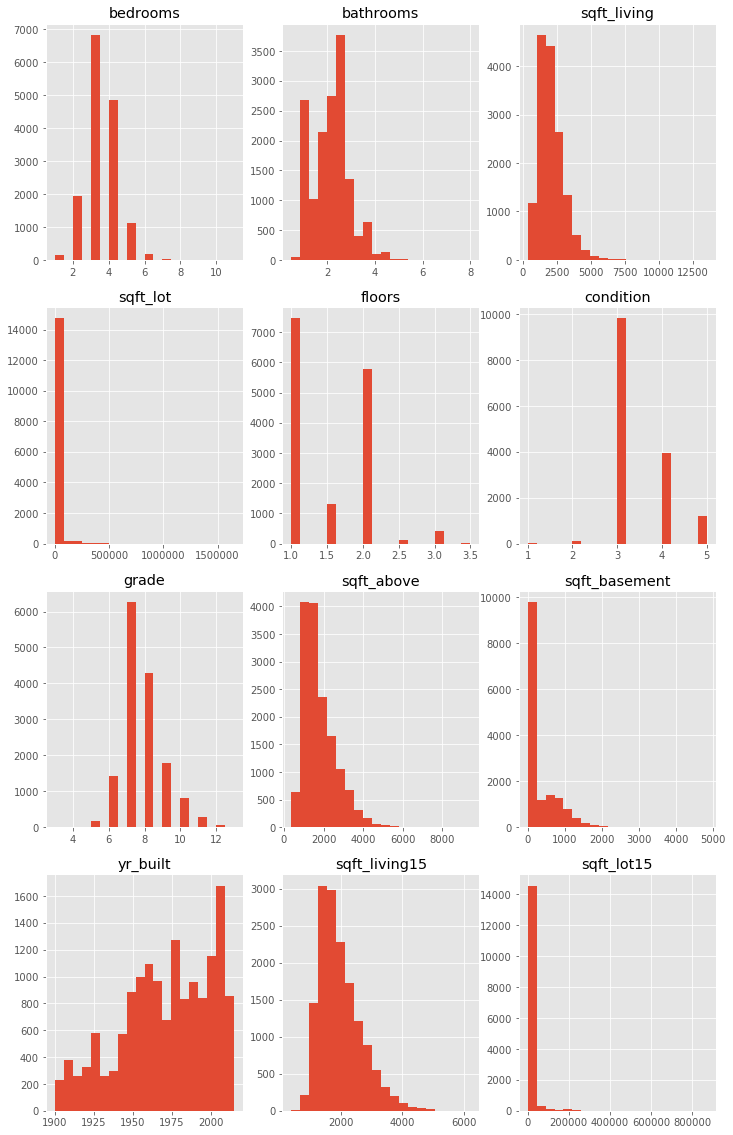

In [96]:
# let's look at the numeric variables.  Are they normally distributed?

numeric = ['bedrooms', 
       'bathrooms', 
       'sqft_living', 
       'sqft_lot', 
       'floors', 
       'condition', 
       'grade',
       'sqft_above', 
       'sqft_basement', 
       'yr_built',
       'sqft_living15', 
       'sqft_lot15'
             ]

num_cols = 3
if len(numeric)%num_cols == 0:
    num_rows = len(numeric)//num_cols
else:
    num_rows = (len(numeric)//num_cols)+1


fig, axs = plt.subplots(figsize=(12,20), nrows=num_rows, ncols=num_cols)


for feat in numeric:
    axs[numeric.index(feat)//num_cols, numeric.index(feat)%num_cols].hist(X_train[feat], bins=20)
    axs[numeric.index(feat)//num_cols, numeric.index(feat)%num_cols].set_title(feat)

In [97]:
# let's try to log these and see if they become more normal
# don't include features with zeros, like sqft_basement

non_zero = ['bedrooms', 
       'bathrooms', 
       'sqft_living', 
       'sqft_lot', 
       'floors', 
       'condition', 
       'grade',
       'sqft_above', 
       'yr_built',
       'sqft_living15', 
       'sqft_lot15'
             ]

X_train_logged = X_train.copy()

for feat in non_zero:
    X_train_logged[feat] = X_train_logged[feat].map(lambda x: np.log(x))


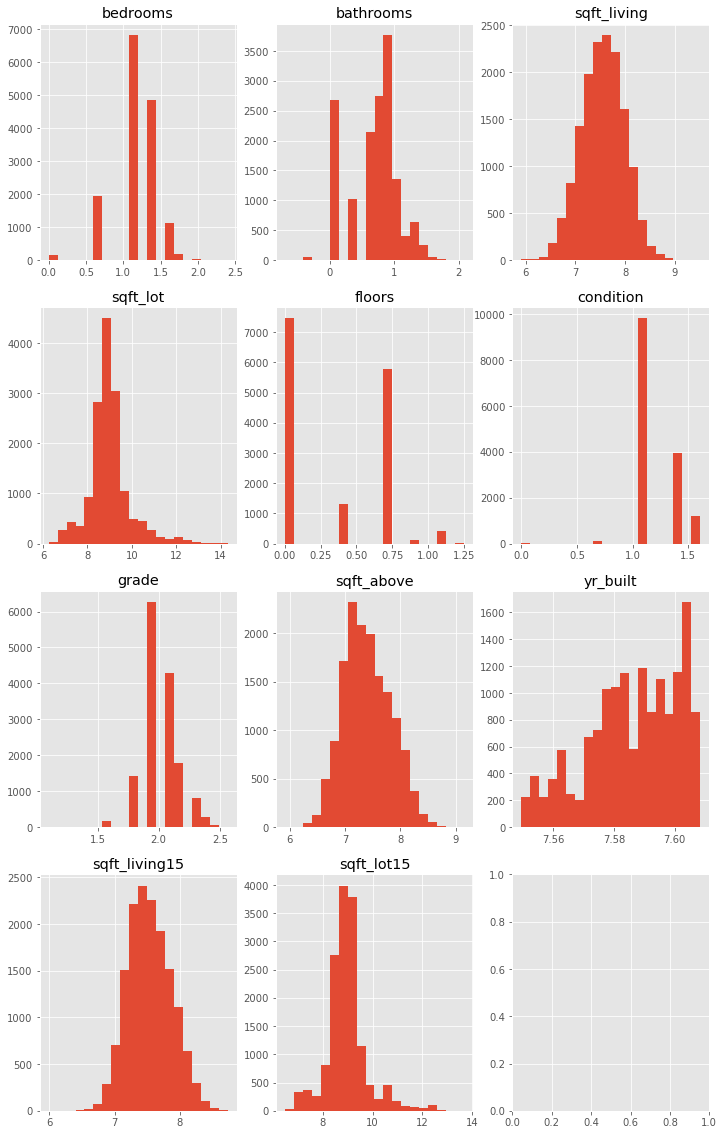

In [98]:
# Did it help?  Make more histograms

num_cols = 3
if len(non_zero)%num_cols == 0:
    num_rows = len(non_zero)//num_cols
else:
    num_rows = (len(non_zero)//num_cols)+1


fig, axs = plt.subplots(figsize=(12,20), nrows=num_rows, ncols=num_cols)


for feat in non_zero:
    axs[non_zero.index(feat)//num_cols, non_zero.index(feat)%num_cols].hist(X_train_logged[feat], bins=20)
    axs[non_zero.index(feat)//num_cols, non_zero.index(feat)%num_cols].set_title(feat)

In [99]:
# yeah, it kinda helped.  A bunch of things look more normal.
# like sqft_living, sqft_lot, grade, sqft_above, sqft_living15, sqft_lot15
# and to a lesser extent, bedrooms and grade too

In [100]:
# what if we build a model with just the above columns logged

# build a new X_train with just the above features logged

to_log = ['bedrooms', 
       'sqft_living', 
       'sqft_lot', 
       'grade',
       'sqft_above', 
       'sqft_living15', 
       'sqft_lot15'
             ]

X_train3 = X_train.copy()

for feat in to_log:
    X_train3[feat] = X_train3[feat].map(lambda x: np.log(x))
    
# log the test data

X_test3 = X_test.copy()

for feat in to_log:
    X_test3[feat] = X_test3[feat].map(lambda x: np.log(x))

In [101]:
# build a function to scale the X variables, and do a linear regression

def scale_lin_reg(X_train, y_train, X_test):
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    linreg = LinearRegression()
    linreg.fit(X_train_scaled, y_train)

    y_train_pred = linreg.predict(X_train_scaled)
    y_test_pred = linreg.predict(X_test_scaled)
    
    return(y_train_pred, y_test_pred)

In [102]:
# let's scale and do a linear regression on the transformed data, to return y_train_pred and y_test_pred
# the inputs X_train3 and X_test3 have 7 features logged

y_train_pred3, y_test_pred3 = scale_lin_reg(X_train=X_train3, y_train=y_train, X_test=X_test3)

In [103]:
# now let's evaluate that model
evaluate_model(y_train=y_train, y_train_pred=y_train_pred3, y_test=y_test, y_test_pred=y_test_pred3)

Training Data 
 R-Squared: 0.59629 
 Mean Absolute Error: 149763.29 
 Root Mean Squared Error: 234324.43 

Testing Data 
 R-Squared: 0.553623 
 Mean Absolute Error: 150183.42 
 Root Mean Squared Error: 243180.35


In [104]:
# oh no!  It didn't help!

In [105]:
# these two features have the most improvement in normality after log transformations:
# sqft_living15
# sqft_lot15

# what if we just log these?

to_log = [
       'sqft_living15', 
       'sqft_lot15'
             ]

X_train4 = X_train.copy()

for feat in to_log:
    X_train4[feat] = X_train4[feat].map(lambda x: np.log(x))

# log the test data

X_test4 = X_test.copy()

for feat in to_log:
    X_test4[feat] = X_test4[feat].map(lambda x: np.log(x))

In [106]:
# let's scale and do a linear regression on the transformed data, to return y_train_pred and y_test_pred
# the inputs X_train4 and X_test4 have 2 features logged

y_train_pred4, y_test_pred4 = scale_lin_reg(X_train=X_train4, y_train=y_train, X_test=X_test4)

In [107]:
# evaluate the model

evaluate_model(y_train=y_train, y_train_pred=y_train_pred4, y_test=y_test, y_test_pred=y_test_pred4)

Training Data 
 R-Squared: 0.629441 
 Mean Absolute Error: 143783.92 
 Root Mean Squared Error: 224497.44 

Testing Data 
 R-Squared: 0.6103 
 Mean Absolute Error: 143442.41 
 Root Mean Squared Error: 227218.12


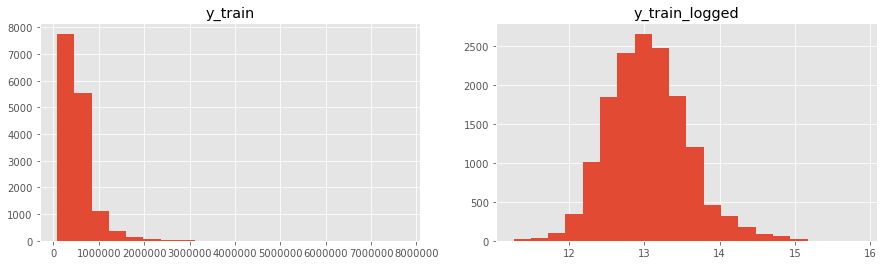

In [108]:
# That is a very slight improvement over the baseline model
# do we need to log the y as well?  Let's try

y_train_logged = y_train.copy()
y_train_logged = y_train_logged.map(lambda y: np.log1p(y))

fig, ax = plt.subplots(figsize = (15,4), nrows=1, ncols=2)

ax[0].hist(y_train, bins=20)
ax[0].set_title('y_train')

ax[1].hist(y_train_logged, bins=20)
ax[1].set_title('y_train_logged');

# the logged y_train definitely looks more normally distributed

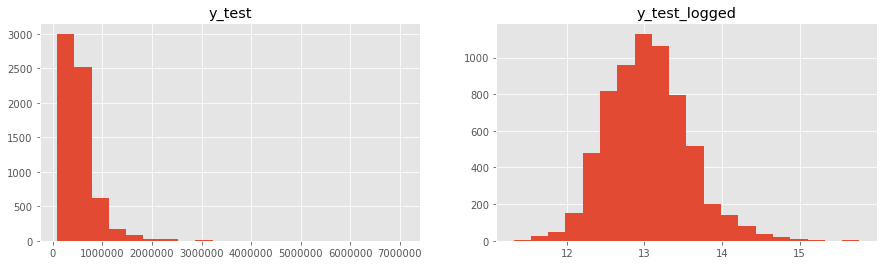

In [109]:
# log y_test as well

y_test_logged = y_test.copy()
y_test_logged = y_test_logged.map(lambda y: np.log1p(y))

fig, ax = plt.subplots(figsize = (15,4), nrows=1, ncols=2)

ax[0].hist(y_test, bins=20)
ax[0].set_title('y_test')

ax[1].hist(y_test_logged, bins=20)
ax[1].set_title('y_test_logged');

# the logged y_test looks more normally distributed too

In [110]:
# now let's run and evaluate the model with X_train4, X_test4, y_train_logged and y_test_logged

y_train_pred5, y_test_pred5 = scale_lin_reg(X_train=X_train4, y_train=y_train_logged, X_test=X_test4)

In [111]:
evaluate_model(y_train=y_train_logged, y_train_pred=y_train_pred5, y_test=y_test_logged, y_test_pred=y_test_pred5)

Training Data 
 R-Squared: 0.664626 
 Mean Absolute Error: 0.24 
 Root Mean Squared Error: 0.31 

Testing Data 
 R-Squared: 0.641326 
 Mean Absolute Error: 0.25 
 Root Mean Squared Error: 0.31


In [112]:
# great, it helped a little, but need to unlog y_train_pred and y_test_pred to get price variance

y_train_pred5_exp = np.expm1(y_train_pred5)
y_test_pred5_exp = np.expm1(y_test_pred5)

In [113]:
evaluate_model(y_train=y_train, y_train_pred=y_train_pred5_exp, y_test=y_test, y_test_pred=y_test_pred5_exp)

Training Data 
 R-Squared: 0.574355 
 Mean Absolute Error: 131424.14 
 Root Mean Squared Error: 240605.85 

Testing Data 
 R-Squared: 0.656868 
 Mean Absolute Error: 132140.77 
 Root Mean Squared Error: 213210.34


In [114]:
# let's try to deal with zipcode
X_train6 = X_train4.copy() # use X_train4, which had two features logged

X_train6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15117 entries, 3372 to 15795
Data columns (total 14 columns):
bedrooms         15117 non-null int64
bathrooms        15117 non-null float64
sqft_living      15117 non-null int64
sqft_lot         15117 non-null int64
floors           15117 non-null float64
condition        15117 non-null int64
grade            15117 non-null int64
sqft_above       15117 non-null int64
sqft_basement    15117 non-null float64
yr_built         15117 non-null int64
zipcode          15117 non-null int64
sqft_living15    15117 non-null float64
sqft_lot15       15117 non-null float64
renovated        15117 non-null int64
dtypes: float64(5), int64(9)
memory usage: 1.7 MB


In [115]:
X_train6['zipcode'].value_counts().count() # 70 different zips
X_train6['zipcode'].value_counts()

# did a little research, 98112 seems to be an expensive neighborhood, at least in 2019
# also 98199 is up there
# https://www.seattlemet.com/home-and-real-estate/2019/03/the-top-12-neighborhoods-in-seattle-2019-edition

98103    443
98052    418
98038    402
98115    400
98117    380
98034    380
98042    376
98133    359
98023    357
98006    337
98118    331
98059    323
98058    315
98155    310
98027    309
98074    296
98033    293
98125    290
98056    283
98053    274
98075    263
98001    248
98126    245
98092    237
98144    232
98106    232
98116    229
98199    228
98029    226
98065    220
98122    214
98004    212
98112    203
98198    199
98028    198
98008    198
98055    198
98003    193
98040    193
98031    193
98178    190
98168    189
98072    189
98177    187
98146    186
98166    185
98136    185
98107    182
98030    170
98045    165
98105    164
98022    153
98108    143
98077    138
98019    134
98011    128
98119    127
98002    127
98005    119
98188    101
98014     97
98007     95
98032     84
98010     77
98070     76
98102     75
98109     72
98024     61
98148     44
98039     37
Name: zipcode, dtype: int64

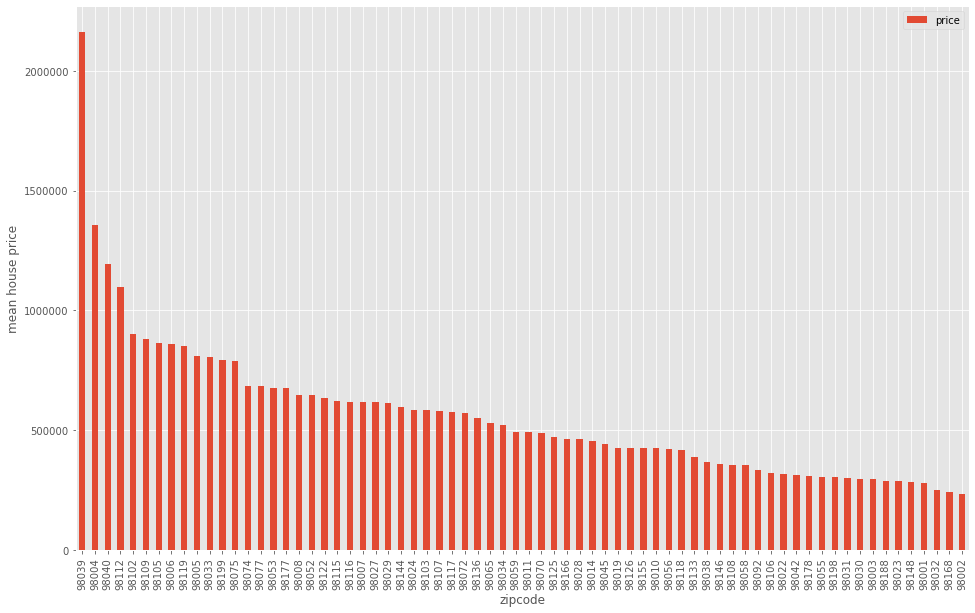

In [116]:
# sum price by zip to see if any stand out

zips = data[['zipcode','price']]
zips_pivot = zips.pivot_table(values='price', index='zipcode', ).sort_values(by='price', ascending=False)
zips_pivot.plot(kind='bar', figsize=(16,10))
plt.ylabel('mean house price')
plt.legend;
# yes, some do stand out!  the top four, the bottom three
# what if I classified them based on price? I can make a dictionary

In [117]:
# create a dictionary of zip codes and classifications

ordered_zip_list = list(zips_pivot.index)
zip_dict = {}

# display all zips and index in price-ordered list for eyeballing

for i in ordered_zip_list:
    print(i, ordered_zip_list.index(i))

98039 0
98004 1
98040 2
98112 3
98102 4
98109 5
98105 6
98006 7
98119 8
98005 9
98033 10
98199 11
98075 12
98074 13
98077 14
98053 15
98177 16
98008 17
98052 18
98122 19
98115 20
98116 21
98007 22
98027 23
98029 24
98144 25
98024 26
98103 27
98107 28
98117 29
98072 30
98136 31
98065 32
98034 33
98059 34
98011 35
98070 36
98125 37
98166 38
98028 39
98014 40
98045 41
98019 42
98126 43
98155 44
98010 45
98056 46
98118 47
98133 48
98038 49
98146 50
98108 51
98058 52
98092 53
98106 54
98022 55
98042 56
98178 57
98055 58
98198 59
98031 60
98030 61
98003 62
98188 63
98023 64
98148 65
98001 66
98032 67
98168 68
98002 69


In [118]:
# classify zips in dict:

zip_dict[ordered_zip_list[0]] = 'Zip Class 1'

# make a function to add entries more easily
def add_to_zip_dict(list_index_start, list_index_stop, category):
    for i in ordered_zip_list[list_index_start:list_index_stop]:
        zip_dict[i] = category

add_to_zip_dict(1, 4, 'Zip Class 2')
add_to_zip_dict(4, 13, 'Zip Class 3')
add_to_zip_dict(13, 34, 'Zip Class 4')
add_to_zip_dict(34, 48, 'Zip Class 5')
add_to_zip_dict(48, 67, 'Zip Class 6')
add_to_zip_dict(67, 70, 'Zip Class 7')

zip_dict

{98039: 'Zip Class 1',
 98004: 'Zip Class 2',
 98040: 'Zip Class 2',
 98112: 'Zip Class 2',
 98102: 'Zip Class 3',
 98109: 'Zip Class 3',
 98105: 'Zip Class 3',
 98006: 'Zip Class 3',
 98119: 'Zip Class 3',
 98005: 'Zip Class 3',
 98033: 'Zip Class 3',
 98199: 'Zip Class 3',
 98075: 'Zip Class 3',
 98074: 'Zip Class 4',
 98077: 'Zip Class 4',
 98053: 'Zip Class 4',
 98177: 'Zip Class 4',
 98008: 'Zip Class 4',
 98052: 'Zip Class 4',
 98122: 'Zip Class 4',
 98115: 'Zip Class 4',
 98116: 'Zip Class 4',
 98007: 'Zip Class 4',
 98027: 'Zip Class 4',
 98029: 'Zip Class 4',
 98144: 'Zip Class 4',
 98024: 'Zip Class 4',
 98103: 'Zip Class 4',
 98107: 'Zip Class 4',
 98117: 'Zip Class 4',
 98072: 'Zip Class 4',
 98136: 'Zip Class 4',
 98065: 'Zip Class 4',
 98034: 'Zip Class 4',
 98059: 'Zip Class 5',
 98011: 'Zip Class 5',
 98070: 'Zip Class 5',
 98125: 'Zip Class 5',
 98166: 'Zip Class 5',
 98028: 'Zip Class 5',
 98014: 'Zip Class 5',
 98045: 'Zip Class 5',
 98019: 'Zip Class 5',
 98126: 'Zi

In [119]:
# add classification column to training data, and drop original zip column

X_train6['zip_class'] = X_train6['zipcode'].map(lambda x: zip_dict[x])
X_train6

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,renovated,zip_class
3372,2,1.75000,1060,16470,1.00000,3,7,1060,0.00000,1977,98072,7.48997,9.72603,0,Zip Class 4
753,2,2.50000,2380,6600,1.00000,3,8,2380,0.00000,2010,98053,7.53369,8.79482,0,Zip Class 4
1418,4,3.75000,3190,17186,2.00000,3,10,3190,0.00000,1999,98178,7.73631,9.51015,0,Zip Class 6
8178,3,2.50000,1730,6930,2.00000,3,8,1730,0.00000,1994,98003,7.48437,8.84362,0,Zip Class 6
2254,4,2.00000,1870,8750,1.00000,3,7,1870,0.00000,1977,98022,7.47873,9.01274,0,Zip Class 6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,3,2.50000,2230,5800,2.00000,3,7,2230,0.00000,2004,98065,7.70976,8.71407,0,Zip Class 4
21576,3,2.25000,1190,1200,3.00000,3,8,1190,0.00000,2008,98103,7.07327,7.10988,0,Zip Class 4
5390,4,1.50000,1530,9000,1.00000,4,6,1530,0.00000,1976,98014,7.32647,9.04782,0,Zip Class 5
860,1,0.75000,380,15000,1.00000,3,5,380,0.00000,1963,98168,7.06476,9.61581,0,Zip Class 7


In [120]:
# one hot encode classification column

zip_class_columns = pd.get_dummies(X_train6['zip_class'], drop_first=True)
zip_class_columns

X_train6 = pd.concat([X_train6, zip_class_columns], axis=1)
X_train6.drop(columns=['zipcode','zip_class'], inplace=True)

In [121]:
# add same features to test set

X_test6 = X_test4
X_test6['zip_class'] = X_test6['zipcode'].map(lambda x: zip_dict[x])

zip_class_columns = pd.get_dummies(X_test6['zip_class'], drop_first=True)
X_test6 = pd.concat([X_test6, zip_class_columns], axis=1)
X_test6.drop(columns=['zipcode','zip_class'], inplace=True)

In [122]:
X_train6 #looks good
X_test6 #looks good

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,renovated,Zip Class 2,Zip Class 3,Zip Class 4,Zip Class 5,Zip Class 6,Zip Class 7
3686,3,0.75000,850,8573,1.00000,3,6,600,250.00000,1945,6.74524,9.03384,0,0,0,0,0,1,0
10247,3,1.00000,1510,6083,1.00000,4,6,860,650.00000,1940,7.31986,8.65032,0,0,0,1,0,0,0
4037,4,2.25000,1790,42000,1.00000,3,7,1170,620.00000,1983,7.63046,10.82166,0,0,0,0,1,0,0
3437,2,1.50000,1140,2500,1.00000,3,7,630,510.00000,1988,7.31322,8.51719,0,0,0,0,0,1,0
19291,3,1.00000,1500,3920,1.00000,3,7,1000,500.00000,1947,7.40245,8.29829,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7677,4,1.75000,2160,7417,1.00000,4,7,1360,800.00000,1983,7.53903,8.98994,0,0,0,0,1,0,0
9400,4,3.50000,2650,3060,2.00000,3,9,2060,590.00000,2001,7.29302,8.02617,0,0,0,1,0,0,0
9092,4,2.75000,2670,6780,2.00000,5,8,1630,1040.00000,1908,7.78322,8.69768,0,0,0,0,1,0,0
6650,3,1.75000,1600,10280,1.00000,3,7,1050,550.00000,1977,7.37149,8.99962,0,0,0,1,0,0,0


In [123]:
y_train_pred6, y_test_pred6 = scale_lin_reg(X_train=X_train6, y_train=y_train_logged, X_test=X_test6)

In [124]:
evaluate_model(y_train=y_train_logged, y_train_pred=y_train_pred6, y_test=y_test_logged, y_test_pred=y_test_pred6)

Training Data 
 R-Squared: 0.827162 
 Mean Absolute Error: 0.16 
 Root Mean Squared Error: 0.22 

Testing Data 
 R-Squared: 0.825669 
 Mean Absolute Error: 0.16 
 Root Mean Squared Error: 0.22


In [125]:
# to evaluate MAE and RMSE, unlog y_train_pred6 and y_test_pred6
y_train_pred6_exp = np.expm1(y_train_pred6)
y_test_pred6_exp = np.expm1(y_test_pred6)

evaluate_model(y_train=y_train, y_train_pred=y_train_pred6_exp, y_test=y_test, y_test_pred=y_test_pred6_exp)

Training Data 
 R-Squared: 0.747537 
 Mean Absolute Error: 93197.2 
 Root Mean Squared Error: 185302.51 

Testing Data 
 R-Squared: 0.798659 
 Mean Absolute Error: 90887.85 
 Root Mean Squared Error: 163321.86


In [126]:
# again, I don't think I should trust the R2 here.  But the MAE and RMSE look good.

In [129]:
# let's remove any multicolinearity
# find top correlations
# code from Flatiron Data Science course's Multicollinearity Lab

df=X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates
df.drop_duplicates(inplace=True)

In [130]:
df[(df.cc>.75) & (df.cc <1)]

# as expected, high correlations among these five variables
# let's drop sqft_living and see what happens

,cc
pairs,
"(sqft_living, sqft_above)",0.87710
"(sqft_living, grade)",0.76381
"(bathrooms, sqft_living)",0.76205
"(sqft_living, sqft_living15)",0.76076
"(sqft_above, grade)",0.75759


In [132]:
# iterated manually thru dropping all five variables, as well as some combinations
# the only one which didn't reduce r2 is sqft_above

X_train7 = X_train6.drop(columns = ['sqft_above','sqft_basement'])
X_test7 = X_test6.drop(columns = ['sqft_above','sqft_basement'])
y_train_pred7, y_test_pred7 = scale_lin_reg(X_train=X_train7, y_train=y_train_logged, X_test=X_test7)
evaluate_model(y_train=y_train_logged, y_train_pred=y_train_pred7, y_test=y_test_logged, y_test_pred=y_test_pred7)

Training Data 
 R-Squared: 0.827084 
 Mean Absolute Error: 0.16 
 Root Mean Squared Error: 0.22 

Testing Data 
 R-Squared: 0.825597 
 Mean Absolute Error: 0.16 
 Root Mean Squared Error: 0.22


In [ ]:
# instead of having the year renovated and the year built, 
# would it help to have a column for built or renovated in the past 10 or 20 years?

# let's look at these columns vs mean price
data_renov = pd.read_csv('data/kc_house_data.csv') # I already removed yr_renovated, so import data again

# first look at yr_renovated
renov_pivot = data_renov.pivot_table(values='price', index='yr_renovated', ).sort_values(by='yr_renovated')
renov_pivot.plot(kind='bar', figsize=(16,10))
plt.ylabel('mean house price')
plt.legend;

# this is hard to interpret, but it looks like the last 20 years could be a predictor

In [ ]:
# now look at yr_built
built_pivot = data_renov.pivot_table(values='price', index='yr_built', ).sort_values(by='yr_built')
built_pivot.plot(kind='bar', figsize=(16,10))
plt.ylabel('mean house price')
plt.legend;

# hmmm, almost looks like older homes and new homes are highly valued, while homes in the middle are not
# should I have only looked at testing data for this?

In [ ]:
# actually it seems these should be separate columns
# one for renovated in the past 20 years, and one segmenting the year built

In [ ]:
# let's make a binary column showing homes renovated in the last 20 years
# since the sale dates are from different years,
# the new column should look at the difference between year sold and year renovated

data_renov['date'].value_counts() 
type(data['date'][0]) # sale dates are strings, must convert to dates

# create a new column for year sold
data_renov['yr_sold'] = pd.to_datetime(data_renov['date']).dt.year
data_renov['yr_sold'].value_counts() # sale dates are from 2014 and 2015

# create a new column showing homes renovated in the last 20 years
data_renov['renov_20_yrs'] = np.where(data_renov['yr_sold']-data_renov['yr_renovated'] < 20, 1, 0)
data_renov['renov_20_yrs'].value_counts() # only 440 homes renovated in last 20 years


In [ ]:
# create a dictionary of years, showing the corresponding categories

years_list = list(built_pivot.index)
years_dict = {}

for i in years_list[0:41]:
    years_dict[i] = 'pre-war'
    
for i in years_list[41:88]:
    years_dict[i] = 'mid-century'

for i in years_list[88:117]:
    years_dict[i] = 'recent'
    
years_dict

In [ ]:
# add a column with yr_built categories

data_renov['built_cat'] = data_renov['yr_built'].map(lambda x: years_dict[x])
data_renov

In [ ]:
# one hot encode classification column

built_cat_columns = pd.get_dummies(data_renov['built_cat'], drop_first=True)
built_cat_columns

data_renov = pd.concat([data_renov, built_cat_columns], axis=1)
data_renov.drop(columns=['yr_built','built_cat'], inplace=True)

In [ ]:
data_renov

In [ ]:
# now we just have to stick these columns back onto the training and test sets

#training set first
X_train9 = X_train8.copy()
columns_to_add = data_renov[['renov_20_yrs', 'pre-war', 'recent']]
X_train9 = pd.concat([X_train9, columns_to_add], axis=1, join='inner')
X_train9 # looks good

# now do test set
X_test9 = X_test8.copy()
X_test9 = pd.concat([X_test9, columns_to_add], axis=1, join='inner')
X_test9 # looks good

# now drop the old renovated and yr_built columns
X_train9.drop(columns=['renovated', 'yr_built'], inplace=True)
X_test9.drop(columns=['renovated', 'yr_built'], inplace=True)

X_train9 # looks good
X_test9 # looks good

In [ ]:
# let's test model 9!

scaler9 = StandardScaler()
X_train9_scaled = scaler9.fit_transform(X_train9)

# scale the test data

X_test9_scaled = scaler9.transform(X_test9)

# now predict the test outcomes and get the r2 and RMSE scores

linreg9 = LinearRegression()
linreg9.fit(X_train9_scaled, y_train)

y_hat_train9 = linreg9.predict(X_train9_scaled)
y_hat_test9 = linreg9.predict(X_test9_scaled)

r2_train9 = round(r2_score(y_true=y_train, y_pred=y_hat_train9), 2)
r2_test9 = round(r2_score(y_true=y_test, y_pred=y_hat_test9), 2)

rmse_train9 = round(np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_hat_train9)), 2)
rmse_test9 = round(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_hat_test9)), 2)

print('\n', 'Training Data', '\n', 
      'R-Squared:', r2_train9, '\n',
      'Root Mean Squared Error:', rmse_train8,)

print('\n',
      'Testing Data', '\n', 
      'R-Squared:', r2_test9, '\n',
      'Root Mean Squared Error:', rmse_test9)

In [ ]:
# NOTHING?!  REALLY?

# check p-values in Statsmodels
# should I be dropping the variables with high p-values?

model = sm.OLS(y_train, X_train9, hasconst=True)
results = model.fit()

results.summary()

In [ ]:
# let's see if Waterfront is a predictor

data['waterfront'].value_counts() # 143 1s, rest are 0s
data['waterfront'].isna().sum() #2376

data_wf = data.loc[(data['waterfront'] == 1) | (data['waterfront'] == 0)]
data_wf


# data_waterfront = data.loc[data['waterfront'] is not 'null']

In [ ]:
# future tweaks

# try to see if waterfront is a predictor?
# use automated feature selection methods?

# use min/max scalar for binary columns? - not a hard and fast rule but maybe will help
# model with just continuous? - didn't work

# look for interactions?
# try different train/test splits
# look at month sold?
# if model predicts something, e.g. over a million, go to a different model?